#  Information Retrieval and Web Search Project



### Alvee Mir - 48590969

### Aims


##### Project Aim:  
> The aim of the entire project is to implement a number of representative information retrieval methods, evaluating and comparing them in the context of real use-cases.

##### Part 2 Aim:
> * Implement neural and generative IR methods introduced in the lectures and pracs.
> * Compare the methods across different IR paradigms: Traditional, Neural, Generative.
> * Reflect on the impact of LLMs on IR, focussing on effectiveness and evaluation.

### The Information Retrieval Task: Web Passage Ranking

In this project, we will consider the (web) passage ranking task in open-domain question answering.

The goal of web passage ranking task is to retrieve and rank passages that best answer user-submitted queries. In a typical web search scenario, users submit queries expecting a ranked list of relevant passages. The core of the task will be to rank these passages effectively to match the intent of each query.

For this task, we will use a **sampled** version of the **MS-MARCO** passage collection. This collection is widely used for training and evaluating passage ranking and retrieval models. The provided queries are real search queries submitted to the Microsoft Bing search engine, and the entire collection consists of approximately 8.8 million passages. To learn more about the collection, you can refer to the original [MS-MARCO paper](https://arxiv.org/abs/1611.09268). We are going to work on a sample of MS-MARCO due to time/hardware/computations required to run experiments on the whole collection.

Recently, emerging Large Language Models (LLMs) show potential in empowering search engines, especially in generating answers to users’ queries. This approach, known as Retrieval-Augmented Generation (RAG), combines Information Retrieval (IR) with generative language models to provide a better user experience. In addition to the passage ranking task, we will also explore the application of RAG and evaluate its performance.

### Review of the IR Workflow
To conduct a complete experiment for the IR tasks in this project, we generally follow three key stages: `Indexing -> Retrieval -> Evaluation`. Each stage involves a corresponding portion of data from the collection. A collection typically comprises a corpus, queries, and a qrel. These are illustrated below:
<center>
<img src="ir-workflow.svg" alt="ir-workflow" width="500" title="Fig.1 IR Workflow"/>
</center>



---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Then navigate to your project folder

In [ ]:
%cd /content/drive/your-project-folder

Next install necessary packages

In [ ]:
!pip install pyserini==0.21.0 faiss-cpu

# Task-1: *Traditional model vs. Neural models*

## 1.1 Data Examination and Indexing

### 1.1.1 Data Examination

In [12]:
# Examining the dataset 
import json

with open('./infs7410_project_part_2_collection/sampled_collection.jsonl', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i < 5:  # Print first 5 documents
            doc = json.loads(line)
            print(f"Document ID: {doc['id']}")
            print(f"Contents: {doc['contents'][:100]}...")  # First 100 characters of contents
            print("---")
        else:
            break

# Count total documents
with open('./infs7410_project_part_2_collection/sampled_collection.jsonl', 'r', encoding='utf-8') as f:
    doc_count = sum(1 for _ in f)
print(f"Total documents in MS-MARCO: {doc_count}")

Document ID: 350
Contents: The melting point of a substance is the temperature at which it changes from. a solid to a liquid. a...
---
Document ID: 11794
Contents: Needed repairs to flooring, siding, deck or interior trim because of water damage, dry rot or other ...
---
Document ID: 19153
Contents: #1, most heart attacks happen in the left ventricle which is the chamber which is responsible for pu...
---
Document ID: 26121
Contents: Goldfish in cool ponds move more slowly than goldfish in very warm ponds. Fancy goldfish in water th...
---
Document ID: 26129
Contents: If youâre not interested in breeding your goldfish then you should keep your temperature at a stea...
---
Total documents in MS-MARCO: 5853


### 1.1.2 Indexing

In [13]:
# Indexing MS-MARCO
!python -m pyserini.index.lucene -collection JsonCollection -generator DefaultLuceneDocumentGenerator \
 -threads 9 -input ./infs7410_project_part_2_collection \
 -index ./indexes/msmarco-index \
 -optimize \
 -storeRaw \
 -stemmer none \
 -keepStopwords \
 -storeDocvectors

2024-10-15 21:12:19,018 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2024-10-15 21:12:19,019 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2024-10-15 21:12:19,019 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2024-10-15 21:12:19,019 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: ./infs7410_project_part_2_collection
2024-10-15 21:12:19,020 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2024-10-15 21:12:19,020 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2024-10-15 21:12:19,020 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 9
2024-10-15 21:12:19,020 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: en
2024-10-15 21:12:19,020 INFO  [main] index.In

## 1.2 Retrieval Models

In [7]:
# Import all python libraries and put your setup code here.
!pip install matplotlib
!pip install seaborn
!pip install pytrec-eval-terrier


In [14]:
stemming = None    
stopwords = False 

### 1.2.1 BM25 

We will use 2 different implementations of BM25:

1. The Pyserini BM25 Implementation: This utilizes the robust and optimized BM25 algorithm integrated within the Pyserini information retrieval toolkit. Pyserini, built on Lucene, offers a high-performance, scalable solution that leverages years of refinement in search technology.

2. Custom BM25 Implementation from Project Part 1: This is our bespoke implementation of the BM25 ranking function, developed as part of the earlier phase of this project. It provides us with a deeper understanding of the algorithm's mechanics and allows for custom modifications.

By comparing these two implementations, we aim to assess the trade-offs between using a well-established library and a custom-built solution. This evaluation will offer insights into performance differences, potential optimizations, and the practical implications of each approach in real-world information retrieval scenarios.

In [30]:
import numpy as np
import math
from pyserini.search import SimpleSearcher
from pyserini.analysis import Analyzer, get_lucene_analyzer
from pyserini.index import IndexReader
from tqdm import tqdm
from collections import defaultdict

# Initialize components
index = 'indexes/msmarco-index/'  
lucene_analyzer = get_lucene_analyzer(stemming=None, stopwords=True) 
analyzer = Analyzer(lucene_analyzer)
searcher = SimpleSearcher(index)
searcher.set_analyzer(lucene_analyzer)
searcher.set_bm25(k1=1.3, b=0.75)

queries = []
with open("./infs7410_project_part_2_collection/sampled_queries.tsv", "r") as f:
    for line in f.readlines():
        parts = line.split("\t")
        # parts[0] ~> topic id
        # parts[1] ~> query
        queries.append((parts[0], parts[1].strip()))

def search(run_file: str, k: int=10):
    with open(run_file, "w") as f:
        for topic_id, query in queries:
            hits = searcher.search(query, k=k*2)  # Search for more results to account for duplicates
            unique_docs = {}
            for hit in hits:
                if hit.docid not in unique_docs:
                    unique_docs[hit.docid] = hit.score
            
            # Sort unique documents by score and write top k results
            sorted_docs = sorted(unique_docs.items(), key=lambda x: x[1], reverse=True)[:k]
            for i, (docid, score) in enumerate(sorted_docs):
                f.write(f"{topic_id} Q0 {docid} {i} {score} msmarco-pyserini_bm25\n")
                

def print_line(measure, scope, value):
    """
    Utility method that nicely prints out our evaluation results.
    """
    print('{:25s}{:8s}{:.4f}'.format(measure, scope, value))        

search("msmarco-pyserini_bm25.run", k=10)

#### Now let's evaluate both our BM25 models using ndcg@3

In [9]:
import pytrec_eval

def load_qrels(file_path):
    qrels = {}
    with open(file_path, 'r') as f:
        for line in f:
            qid, _, docid, rel = line.strip().split()
            if qid not in qrels:
                qrels[qid] = {}
            qrels[qid][docid] = int(rel)
    return qrels

def load_run(file_path):
    run = {}
    with open(file_path, 'r') as f:
        for line in f:
            qid, _, docid, rank, score, _ = line.strip().split()
            if qid not in run:
                run[qid] = {}
            run[qid][docid] = float(score)
    return run

def evaluate_run(run_results, qrels):
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, measures=["ndcg_cut_3"])
    results = evaluator.evaluate(run_results)
    
    ndcg_scores = {query: query_measures['ndcg_cut_3'] for query, query_measures in results.items()}
    mean_ndcg = sum(ndcg_scores.values()) / len(ndcg_scores)
    
    return mean_ndcg, ndcg_scores

#_______________________#_______________________#_______________________#_______________________#_______________________
# Load qrels and run
qrels = load_qrels('./infs7410_project_part_2_collection/sampled_qrels.txt')
run_file_path = 'msmarco-pyserini_bm25.run'
run = load_run(run_file_path)

# Evaluate run
mean_ndcg, individual_ndcg_scores = evaluate_run(run, qrels)

# Print result
print(f"nDCG@3 for the pyserini BM25 run: {mean_ndcg:.4f}")

# Write results to file
output_file_path = 'msmarco_pyserini_bm25_ndcg3.txt'
with open(output_file_path, 'w') as f:
    f.write(f"Mean nDCG@3 for the pyserini BM25 run : {mean_ndcg:.4f}\n")
    f.write("Individual query nDCG@3 scores:\n")
    for query, score in individual_ndcg_scores.items():
        f.write(f"Query {query}: {score:.4f}\n")

print(f"Results have been written to {output_file_path}")

nDCG@3 for the pyserini BM25 run: 0.4753
Results have been written to msmarco_pyserini_bm25_ndcg3.txt


------

### 1.2.2 DPR

In [63]:
import json
import csv
from tqdm import tqdm
import numpy as np
import torch
from transformers import DPRQuestionEncoder, DPRContextEncoder, DPRQuestionEncoderTokenizer, DPRContextEncoderTokenizer

# Load the DPR models and tokenizers
question_model_name = "facebook/dpr-question_encoder-single-nq-base"
context_model_name = "facebook/dpr-ctx_encoder-single-nq-base"
print("Loading models and tokenizers...")
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained(question_model_name)
question_model = DPRQuestionEncoder.from_pretrained(question_model_name)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained(context_model_name)
context_model = DPRContextEncoder.from_pretrained(context_model_name)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")
question_model.to(device)
context_model.to(device)

def encode_text(text, model, tokenizer, max_length=512):
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, padding="max_length", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.pooler_output.cpu().numpy().flatten()

# Load passages
print("Loading passages...")
passages = {}
with open('./infs7410_project_part_2_collection/sampled_collection.jsonl', 'r') as f:
    for line in tqdm(f, desc="Loading passages"):
        data = json.loads(line)
        passages[data['id']] = data['contents']

# Encode passages
print("Encoding passages...")
passage_embeddings = {}
for pid, text in tqdm(passages.items(), desc="Encoding passages"):
    passage_embeddings[pid] = encode_text(text, context_model, context_tokenizer)

# Convert passage embeddings to a 2D numpy array
passage_embedding_matrix = np.array(list(passage_embeddings.values()))

# Load and encode queries
print("Loading and encoding queries...")
queries = {}
with open('./infs7410_project_part_2_collection/sampled_queries.tsv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in tqdm(reader, desc="Loading queries"):
        qid, query_text = row
        queries[qid] = query_text

query_embeddings = {}
for qid, text in tqdm(queries.items(), desc="Encoding queries"):
    query_embeddings[qid] = encode_text(text, question_model, question_tokenizer)

# Perform retrieval
def retrieve_top_k(query_embedding, passage_embedding_matrix, passage_ids, k=10):
    similarities = np.dot(passage_embedding_matrix, query_embedding)
    top_k_indices = similarities.argsort()[-k:][::-1]
    return [(passage_ids[i], similarities[i]) for i in top_k_indices]

print("Performing retrieval...")
results = {}
passage_ids = list(passage_embeddings.keys())
for qid, q_emb in tqdm(query_embeddings.items(), desc="Retrieving top-10 passages"):
    results[qid] = retrieve_top_k(q_emb, passage_embedding_matrix, passage_ids, k=10)

# Save results in .run format
print("Saving results...")
with open('dpr_results.run', 'w') as f:
    for qid, passages in tqdm(results.items(), desc="Writing results"):
        for rank, (pid, score) in enumerate(passages, 1):
            f.write(f"{qid} Q0 {pid} {rank} {score} DPR\n")

print("Retrieval complete. Results saved to dpr_results.run")

Loading models and tokenizers...


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRCon

Using device: mps
Loading passages...


Loading passages: 5853it [00:00, 248955.59it/s]


Encoding passages...


Encoding passages: 100%|██████████| 5853/5853 [05:07<00:00, 19.05it/s]


Loading and encoding queries...


Loading queries: 10it [00:00, 10384.51it/s]
Encoding queries: 100%|██████████| 10/10 [00:00<00:00, 18.62it/s]


Performing retrieval...


Retrieving top-10 passages: 100%|██████████| 10/10 [00:00<00:00, 152.24it/s]


Saving results...


Writing results: 100%|██████████| 10/10 [00:00<00:00, 1070.11it/s]

Retrieval complete. Results saved to dpr_results.run


#### Now let's evaluate our DPR run using ndcg@3

In [64]:
import pytrec_eval

def load_qrels(file_path):
    qrels = {}
    with open(file_path, 'r') as f:
        for line in f:
            qid, _, docid, rel = line.strip().split()
            if qid not in qrels:
                qrels[qid] = {}
            qrels[qid][docid] = int(rel)
    return qrels

def load_run(file_path):
    run = {}
    with open(file_path, 'r') as f:
        for line in f:
            qid, _, docid, rank, score, _ = line.strip().split()
            if qid not in run:
                run[qid] = {}
            run[qid][docid] = float(score)
    return run

def evaluate_run(run_results, qrels):
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, measures=["ndcg_cut_3"])
    results = evaluator.evaluate(run_results)
    
    ndcg_scores = {query: query_measures['ndcg_cut_3'] for query, query_measures in results.items()}
    mean_ndcg = sum(ndcg_scores.values()) / len(ndcg_scores)
    
    return mean_ndcg, ndcg_scores

# Load qrels and run
qrels = load_qrels('./infs7410_project_part_2_collection/sampled_qrels.txt')
run_file_path = 'dpr_results.run'
run = load_run(run_file_path)

# Evaluate run
mean_ndcg, individual_ndcg_scores = evaluate_run(run, qrels)

# Print result
print(f"nDCG@3 for the DPR: {mean_ndcg:.4f}")

# Write results to file
output_file_path = 'msmarco_dpr_ndcg3.txt'
with open(output_file_path, 'w') as f:
    f.write(f"Mean nDCG@3 for the DPR run: {mean_ndcg:.4f}\n")
    f.write("Individual query nDCG@3 scores:\n")
    for query, score in individual_ndcg_scores.items():
        f.write(f"Query {query}: {score:.4f}\n")

print(f"Results have been written to {output_file_path}")


nDCG@3 for the DPR: 0.4731
Results have been written to msmarco_dpr_ndcg3.txt


In [39]:
pip install -U sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 4.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


-------

### 1.2.3 TILDEv2
-------

In [1]:
import json
import csv
from tqdm import tqdm
import numpy as np
import torch
from transformers import AutoTokenizer
from modeling import TILDEv2

# Load the TILDEv2 model and tokenizer
print("Loading model and tokenizer...")
model = TILDEv2.from_pretrained("ielab/TILDEv2-noExp").eval()
tokenizer = AutoTokenizer.from_pretrained("ielab/TILDEv2-noExp")

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)
print(f"Model loaded and moved to {device}")

def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        token_ids, token_weights = model.encode(**inputs)
    # Convert lists to numpy arrays
    return np.array(token_ids), np.array(token_weights)

def tildev2_scoring(query_ids, document_token_ids, document_token_weights):
    score = 0
    for q_id in query_ids:
        idx = np.where(document_token_ids == q_id)
        if len(idx[0]) != 0:
            score += np.max(document_token_weights[idx])
    return score

# Load passages
print("Loading passages...")
passages = {}
with open('./infs7410_project_part_2_collection/sampled_collection.jsonl', 'r') as f:
    for line in tqdm(f, desc="Loading passages"):
        data = json.loads(line)
        passages[data['id']] = data['contents']

# Encode passages
print("Encoding passages...")
passage_embeddings = {}
for pid, text in tqdm(passages.items(), desc="Encoding passages"):
    passage_embeddings[pid] = encode_text(text)

# Load and encode queries
print("Loading and encoding queries...")
queries = {}
with open('./infs7410_project_part_2_collection/sampled_queries.tsv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in tqdm(reader, desc="Loading queries"):
        qid, query_text = row
        queries[qid] = query_text

query_embeddings = {}
for qid, text in tqdm(queries.items(), desc="Encoding queries"):
    query_embeddings[qid] = encode_text(text)

# Perform retrieval
def retrieve_top_k(query_embedding, passage_embeddings, k=10):
    scores = []
    query_ids, _ = query_embedding  # We don't use query weights in scoring
    for pid, (token_ids, token_weights) in passage_embeddings.items():
        score = tildev2_scoring(query_ids, token_ids, token_weights)
        scores.append((pid, score))
    return sorted(scores, key=lambda x: x[1], reverse=True)[:k]

print("Performing retrieval...")
results = {}
for qid, q_emb in tqdm(query_embeddings.items(), desc="Retrieving top-10 passages"):
    results[qid] = retrieve_top_k(q_emb, passage_embeddings, k=10)

# Save results in .run format
print("Saving results...")
with open('tildev2_results.run', 'w') as f:
    for qid, passages in tqdm(results.items(), desc="Writing results"):
        for rank, (pid, score) in enumerate(passages, 1):
            f.write(f"{qid} Q0 {pid} {rank} {score} TILDEv2\n")

print("Retrieval complete. Results saved to tildev2_results.run")

/opt/anaconda3/envs/infs7410/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model and tokenizer...
Model loaded and moved to cpu
Loading passages...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading passages: 5853it [00:00, 294963.97it/s]


Encoding passages...


Encoding passages: 100%|██████████| 5853/5853 [04:32<00:00, 21.45it/s]


Loading and encoding queries...


Loading queries: 10it [00:00, 45197.24it/s]
Encoding queries: 100%|██████████| 10/10 [00:00<00:00, 22.37it/s]


Performing retrieval...


Retrieving top-10 passages: 100%|██████████| 10/10 [00:00<00:00, 25.42it/s]


Saving results...


Writing results: 100%|██████████| 10/10 [00:00<00:00, 21055.74it/s]

Retrieval complete. Results saved to tildev2_results.run


#### Now let us evaluate our TILDEv2 run

In [2]:
import pytrec_eval

def load_qrels(file_path):
    qrels = {}
    with open(file_path, 'r') as f:
        for line in f:
            qid, _, docid, rel = line.strip().split()
            if qid not in qrels:
                qrels[qid] = {}
            qrels[qid][docid] = int(rel)
    return qrels

def load_run(file_path):
    run = {}
    with open(file_path, 'r') as f:
        for line in f:
            qid, _, docid, rank, score, _ = line.strip().split()
            if qid not in run:
                run[qid] = {}
            run[qid][docid] = float(score)
    return run

def evaluate_run(run_results, qrels):
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, measures=["ndcg_cut_3"])
    results = evaluator.evaluate(run_results)
    
    ndcg_scores = {query: query_measures['ndcg_cut_3'] for query, query_measures in results.items()}
    mean_ndcg = sum(ndcg_scores.values()) / len(ndcg_scores)
    
    return mean_ndcg, ndcg_scores

# Load qrels and run
qrels = load_qrels('./infs7410_project_part_2_collection/sampled_qrels.txt')
run_file_path = 'tildev2_results.run'
run = load_run(run_file_path)

# Evaluate run
mean_ndcg, individual_ndcg_scores = evaluate_run(run, qrels)

# Print result
print(f"nDCG@3 for TILDEv2: {mean_ndcg:.4f}")

# Write results to file
output_file_path = 'msmarco_tildev2_ndcg3.txt'
with open(output_file_path, 'w') as f:
    f.write(f"Mean nDCG@3 for the TILDEv2 run: {mean_ndcg:.4f}\n")
    f.write("Individual query nDCG@3 scores:\n")
    for query, score in individual_ndcg_scores.items():
        f.write(f"Query {query}: {score:.4f}\n")

print(f"Results have been written to {output_file_path}")

nDCG@3 for TILDEv2: 0.7650
Results have been written to msmarco_tildev2_ndcg3.txt


### 1.2.4 Bonus: Point-wise and Pair-wise reranking

For our reranking task on the MS MARCO dataset, we selected the Cross-Encoder MiniLM model, specifically the "cross-encoder/ms-marco-MiniLM-L-6-v2" variant. This model was chosen for its balance of efficiency and effectiveness in passage ranking tasks. Cross-Encoder models are known for their strong performance in reranking scenarios as they directly compare query-document pairs, capturing intricate relevance patterns. The MiniLM architecture, a compressed version of BERT, offers computational efficiency without significantly compromising on performance. Importantly, this particular model has been fine-tuned on the MS MARCO dataset, making it especially suitable for our task. By implementing both pointwise and pairwise reranking approaches with this model, we aim to leverage its strengths in capturing relevance while exploring different ranking paradigms.

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import json
import csv
import gc
from itertools import combinations

# Load Cross-Encoder MiniLM model and tokenizer
model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
print(f"Loading {model_name} model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded and moved to {device}")

# Load passages
print("Loading passages...")
passages = {}
with open('./infs7410_project_part_2_collection/sampled_collection.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        passages[data['id']] = data['contents']

# Load queries
print("Loading queries...")
queries = {}
with open('./infs7410_project_part_2_collection/sampled_queries.tsv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        qid, query_text = row
        queries[qid] = query_text

# Load TILDEv2 results
print("Loading TILDEv2 results...")
tildev2_results = {}
with open('tildev2_results.run', 'r') as f:
    for line in f:
        qid, _, docid, rank, score, _ = line.strip().split()
        if int(rank) <= 10:  # Only consider top 10 results
            if qid not in tildev2_results:
                tildev2_results[qid] = []
            tildev2_results[qid].append((docid, float(score)))

def get_relevance_score(query, passage):
    inputs = tokenizer(query, passage, return_tensors="pt", truncation=True, max_length=512, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits.squeeze().item()

def pointwise_rerank(query, docs):
    doc_scores = []
    for doc_id, _ in docs:
        score = get_relevance_score(query, passages[doc_id])
        doc_scores.append((doc_id, score))
    return sorted(doc_scores, key=lambda x: x[1], reverse=True)

def pairwise_rerank(query, docs):
    doc_scores = {doc_id: 0 for doc_id, _ in docs}
    for (doc_id1, _), (doc_id2, _) in combinations(docs, 2):
        score1 = get_relevance_score(query, passages[doc_id1])
        score2 = get_relevance_score(query, passages[doc_id2])
        if score1 > score2:
            doc_scores[doc_id1] += 1
        else:
            doc_scores[doc_id2] += 1
    return sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)

# Perform reranking
print("Starting reranking process...")
pointwise_results = {}
pairwise_results = {}

try:
    for i, (qid, docs) in enumerate(tqdm(tildev2_results.items(), desc="Reranking queries")):
        query = queries[qid]
        pointwise_results[qid] = pointwise_rerank(query, docs)
        pairwise_results[qid] = pairwise_rerank(query, docs)
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1} queries")
            # Clear CUDA cache if using GPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            # Force garbage collection
            gc.collect()

except Exception as e:
    print(f"An error occurred during reranking: {str(e)}")
    # Save partial results
    print("Saving partial results...")

# Save pointwise reranking results
print("Saving pointwise reranking results...")
with open('cross_encoder_minilm_pointwise_rerank.run', 'w') as f:
    for qid, docs in pointwise_results.items():
        for rank, (doc_id, score) in enumerate(docs, 1):
            f.write(f"{qid} Q0 {doc_id} {rank} {score} Cross-Encoder-MiniLM-Pointwise\n")

# Save pairwise reranking results
print("Saving pairwise reranking results...")
with open('cross_encoder_minilm_pairwise_rerank.run', 'w') as f:
    for qid, docs in pairwise_results.items():
        for rank, (doc_id, score) in enumerate(docs, 1):
            f.write(f"{qid} Q0 {doc_id} {rank} {score} Cross-Encoder-MiniLM-Pairwise\n")

print("Reranking complete. Results saved to cross_encoder_minilm_pointwise_rerank.run and cross_encoder_minilm_pairwise_rerank.run")

Loading cross-encoder/ms-marco-MiniLM-L-6-v2 model and tokenizer...
Model loaded and moved to cpu
Loading passages...
Loading queries...
Loading TILDEv2 results...
Starting reranking process...


Reranking queries: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

Processed 10 queries
Saving pointwise reranking results...
Saving pairwise reranking results...
Reranking complete. Results saved to cross_encoder_minilm_pointwise_rerank.run and cross_encoder_minilm_pairwise_rerank.run


#### Let us evaluate our pointwise and pairwise re-ranking

In [11]:
import pytrec_eval

def load_qrels(file_path):
    qrels = {}
    with open(file_path, 'r') as f:
        for line in f:
            qid, _, docid, rel = line.strip().split()
            if qid not in qrels:
                qrels[qid] = {}
            qrels[qid][docid] = int(rel)
    return qrels

def load_run(file_path):
    run = {}
    with open(file_path, 'r') as f:
        for line in f:
            qid, _, docid, rank, score, _ = line.strip().split()
            if qid not in run:
                run[qid] = {}
            run[qid][docid] = float(score)
    return run

def evaluate_run(run_results, qrels):
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, measures=["ndcg_cut_3"])
    results = evaluator.evaluate(run_results)
    
    ndcg_scores = {query: query_measures['ndcg_cut_3'] for query, query_measures in results.items()}
    mean_ndcg = sum(ndcg_scores.values()) / len(ndcg_scores)
    
    return mean_ndcg, ndcg_scores

# Load qrels
qrels = load_qrels('./infs7410_project_part_2_collection/sampled_qrels.txt')

# Load and evaluate runs
runs = {
    'Cross-Encoder MiniLM Pointwise': 'cross_encoder_minilm_pointwise_rerank.run',
    'Cross-Encoder MiniLM Pairwise': 'cross_encoder_minilm_pairwise_rerank.run',
    'TILDEv2': 'tildev2_results.run'
}

results = {}
for name, file_path in runs.items():
    run = load_run(file_path)
    mean_ndcg, individual_ndcg_scores = evaluate_run(run, qrels)
    results[name] = {
        'mean_ndcg': mean_ndcg,
        'individual_scores': individual_ndcg_scores
    }

# Print results and write to separate files
for name, result in results.items():
    output_file_path = f'{name.lower().replace(" ", "_")}_evaluation_results.txt'
    with open(output_file_path, 'w') as f:
        print(f"nDCG@3 for {name}: {result['mean_ndcg']:.4f}")
        f.write(f"Mean nDCG@3 for {name}: {result['mean_ndcg']:.4f}\n")
        f.write(f"Individual query nDCG@3 scores for {name}:\n")
        for query, score in result['individual_scores'].items():
            f.write(f"Query {query}: {score:.4f}\n")
    print(f"Results for {name} have been written to {output_file_path}")

# Calculate and print improvement over TILDEv2
if 'TILDEv2' in results:
    tildev2_ndcg = results['TILDEv2']['mean_ndcg']
    for name in ['Cross-Encoder MiniLM Pointwise', 'Cross-Encoder MiniLM Pairwise']:
        if name in results:
            improvement = results[name]['mean_ndcg'] - tildev2_ndcg
            percentage_improvement = (improvement / tildev2_ndcg) * 100
            print(f"\nImprovement of {name} over TILDEv2: {improvement:.4f}")
            print(f"Percentage improvement: {percentage_improvement:.2f}%")

nDCG@3 for Cross-Encoder MiniLM Pointwise: 0.7929
Results for Cross-Encoder MiniLM Pointwise have been written to cross-encoder_minilm_pointwise_evaluation_results.txt
nDCG@3 for Cross-Encoder MiniLM Pairwise: 0.7929
Results for Cross-Encoder MiniLM Pairwise have been written to cross-encoder_minilm_pairwise_evaluation_results.txt
nDCG@3 for TILDEv2: 0.7650
Results for TILDEv2 have been written to tildev2_evaluation_results.txt

Improvement of Cross-Encoder MiniLM Pointwise over TILDEv2: 0.0279
Percentage improvement: 3.65%

Improvement of Cross-Encoder MiniLM Pairwise over TILDEv2: 0.0279
Percentage improvement: 3.65%


-------

## 1.3 Evaluation


### 1.3.1 Significance Tests using BM25 as the Baseline

In [16]:
import numpy as np
from scipy import stats

def load_scores(file_path):
    scores = {}
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith("Query"):
                query_id, score = line.strip().split(": ")
                query_id = query_id.split()[1]  # Extract the query ID
                scores[query_id] = float(score)
    return scores

def perform_paired_ttest(baseline_scores, model_scores, baseline_name, model_name):
    # Ensure we're comparing the same queries
    common_queries = set(baseline_scores.keys()) & set(model_scores.keys())
    baseline_filtered = [baseline_scores[q] for q in common_queries]
    model_filtered = [model_scores[q] for q in common_queries]

    t_statistic, p_value = stats.ttest_rel(baseline_filtered, model_filtered)
    
    print(f"Paired t-test results for {model_name} vs {baseline_name}:")
    print(f"t-statistic: {t_statistic}")
    print(f"p-value: {p_value}")
    
    if p_value < 0.01:
        significance = "** (p < 0.01)"
    elif p_value < 0.05:
        significance = "* (p < 0.05)"
    else:
        significance = "(not significant)"
    
    print(f"Significance: {significance}\n")
    
    return t_statistic, p_value, significance

# Load scores for each model
bm25_scores = load_scores("msmarco_pyserini_bm25_ndcg3.txt")
dpr_scores = load_scores("msmarco_dpr_ndcg3.txt")
tildev2_scores = load_scores("msmarco_tildev2_ndcg3.txt")
cross_encoder_pointwise_scores = load_scores("cross-encoder_minilm_pairwise_evaluation_results.txt")
cross_encoder_pairwise_scores = load_scores("cross-encoder_minilm_pairwise_evaluation_results.txt")

# Perform paired t-tests against BM25 baseline
baseline_name = "BM25"
models = [
    ("DPR", dpr_scores),
    ("TILDEv2", tildev2_scores),
    ("Cross-Encoder MiniLM Pointwise", cross_encoder_pointwise_scores),
    ("Cross-Encoder MiniLM Pairwise", cross_encoder_pairwise_scores)
]

results = []

for model_name, model_scores in models:
    t_statistic, p_value, significance = perform_paired_ttest(
        bm25_scores, model_scores, baseline_name, model_name
    )
    
    results.append({
        "Model": model_name,
        "t-statistic": t_statistic,
        "p-value": p_value,
        "Significance": significance
    })

# The results list now contains comparisons of each model against BM25
# We'll use this to create a markdown table later

Paired t-test results for DPR vs BM25:
t-statistic: 0.032278631522238865
p-value: 0.9749543607065105
Significance: (not significant)

Paired t-test results for TILDEv2 vs BM25:
t-statistic: -3.101084347976668
p-value: 0.012700214790191277
Significance: * (p < 0.05)

Paired t-test results for Cross-Encoder MiniLM Pointwise vs BM25:
t-statistic: -3.330844035615104
p-value: 0.008787269999060725
Significance: ** (p < 0.01)

Paired t-test results for Cross-Encoder MiniLM Pairwise vs BM25:
t-statistic: -3.330844035615104
p-value: 0.008787269999060725
Significance: ** (p < 0.01)



### 1.3.2 Combining the results

| Model | Mean nDCG@3 | Improvement over BM25 | t-statistic | p-value | Significance |
|-------|-------------|----------------------|-------------|---------|--------------|
| BM25 (baseline) | 0.4753 | - | - | - | - |
| DPR | 0.4731 | -0.0022 | 0.0323 | 0.9750 | (not significant) |
| TILDEv2 | 0.7650 | +0.2897 | -3.1011 | 0.0127 | * (p < 0.05) |
| Cross-Encoder MiniLM Pointwise | 0.7929 | +0.3176 | -3.3308 | 0.0088 | ** (p < 0.01) |
| Cross-Encoder MiniLM Pairwise | 0.7929 | +0.3176 | -3.3308 | 0.0088 | ** (p < 0.01) |

### 1.3.3 Plotting Gain Loss plots

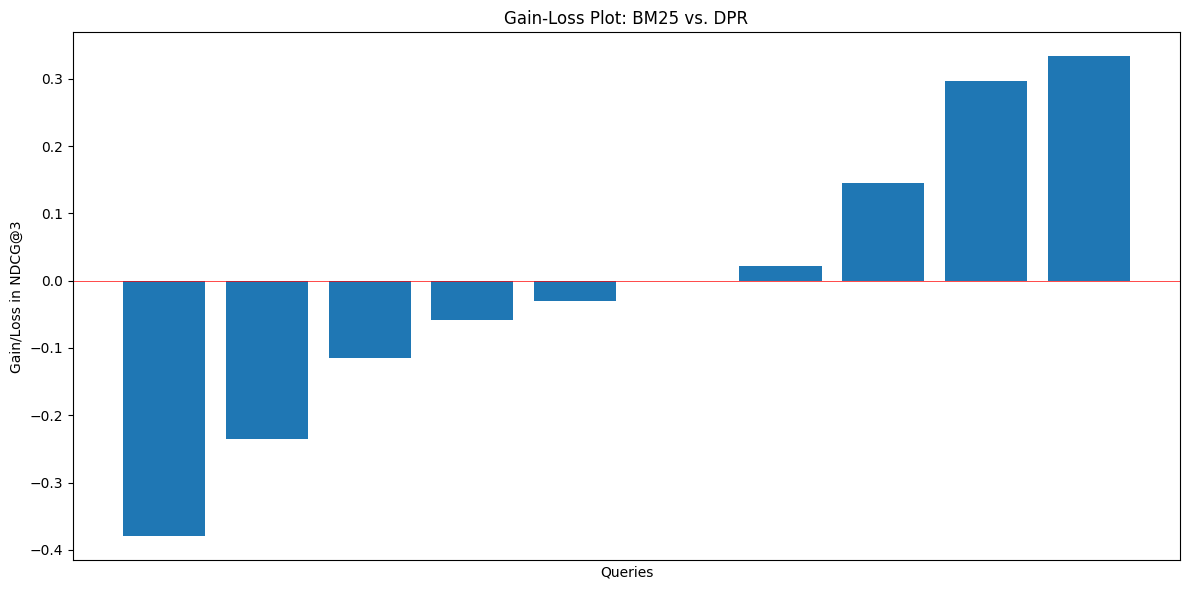

Average gain in NDCG@3: -0.0022


In [21]:
import pytrec_eval
import numpy as np
import matplotlib.pyplot as plt

# Load TREC-COVID qrels
with open('./infs7410_project_part_2_collection/sampled_qrels.txt', 'r') as f:
    qrels = pytrec_eval.parse_qrel(f)

# Initialize evaluator
evaluator = pytrec_eval.RelevanceEvaluator(qrels, measures=["ndcg_cut_3"])

# Load run files
with open('msmarco-pyserini_bm25.run', 'r') as f:
    baseline_run = pytrec_eval.parse_run(f)

# Choose the dpr run
with open('dpr_results.run', 'r') as f:
    dpr_run = pytrec_eval.parse_run(f)

# Evaluate runs
baseline_results = evaluator.evaluate(baseline_run)
dpr_results = evaluator.evaluate(dpr_run)

# Extract NDCG@10 scores
measure = "ndcg_cut_3"
baseline_scores = {query: results[measure] for query, results in baseline_results.items()}
dpr_scores = {query: results[measure] for query, results in dpr_results.items()}

# Calculate differences
differences = []
queries = []
for query in baseline_scores.keys():
    if query in dpr_scores:
        diff = dpr_scores[query] - baseline_scores[query]
        differences.append(diff)
        queries.append(query)

# Sort differences for gain-loss plot
sorted_indices = np.argsort(differences)
sorted_differences = np.array(differences)[sorted_indices]
sorted_queries = np.array(queries)[sorted_indices]

# Create gain-loss plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_differences)), sorted_differences)
plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
plt.title("Gain-Loss Plot: BM25 vs. DPR")
plt.xlabel("Queries")
plt.ylabel("Gain/Loss in NDCG@3")
plt.xticks([])  # Remove x-axis labels for clarity
plt.tight_layout()
plt.show()

# Print average difference
avg_diff = np.mean(differences)
print(f"Average gain in NDCG@3: {avg_diff:.4f}")

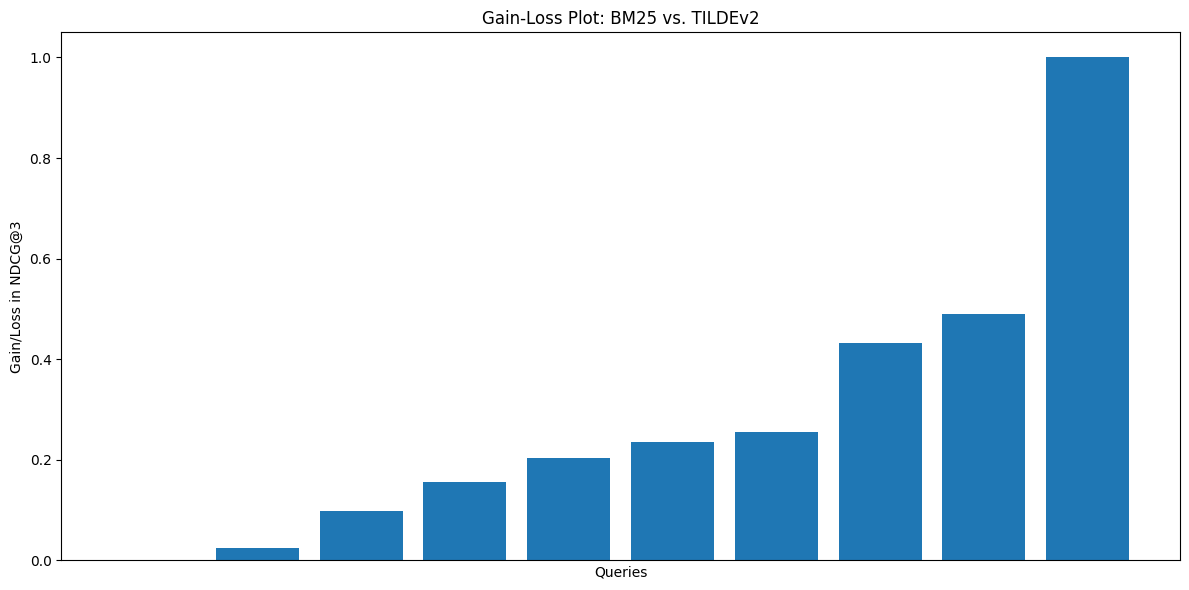

Average gain in NDCG@3: 0.2897


In [23]:
import pytrec_eval
import numpy as np
import matplotlib.pyplot as plt

# Load qrels
with open('./infs7410_project_part_2_collection/sampled_qrels.txt', 'r') as f:
    qrels = pytrec_eval.parse_qrel(f)

# Initialize evaluator
evaluator = pytrec_eval.RelevanceEvaluator(qrels, measures=["ndcg_cut_3"])

# Load run files
with open('msmarco-pyserini_bm25.run', 'r') as f:
    baseline_run = pytrec_eval.parse_run(f)

# Choose the tildev2 run
with open('tildev2_results.run', 'r') as f:
    tildev2_run = pytrec_eval.parse_run(f)

# Evaluate runs
baseline_results = evaluator.evaluate(baseline_run)
tildev2_results = evaluator.evaluate(tildev2_run)

# Extract NDCG@10 scores
measure = "ndcg_cut_3"
baseline_scores = {query: results[measure] for query, results in baseline_results.items()}
tildev2_scores = {query: results[measure] for query, results in tildev2_results.items()}

# Calculate differences
differences = []
queries = []
for query in baseline_scores.keys():
    if query in tildev2_scores:
        diff = tildev2_scores[query] - baseline_scores[query]
        differences.append(diff)
        queries.append(query)

# Sort differences for gain-loss plot
sorted_indices = np.argsort(differences)
sorted_differences = np.array(differences)[sorted_indices]
sorted_queries = np.array(queries)[sorted_indices]

# Create gain-loss plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_differences)), sorted_differences)
plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
plt.title("Gain-Loss Plot: BM25 vs. TILDEv2")
plt.xlabel("Queries")
plt.ylabel("Gain/Loss in NDCG@3")
plt.xticks([])  # Remove x-axis labels for clarity
plt.tight_layout()
plt.show()

# Print average difference
avg_diff = np.mean(differences)
print(f"Average gain in NDCG@3: {avg_diff:.4f}")

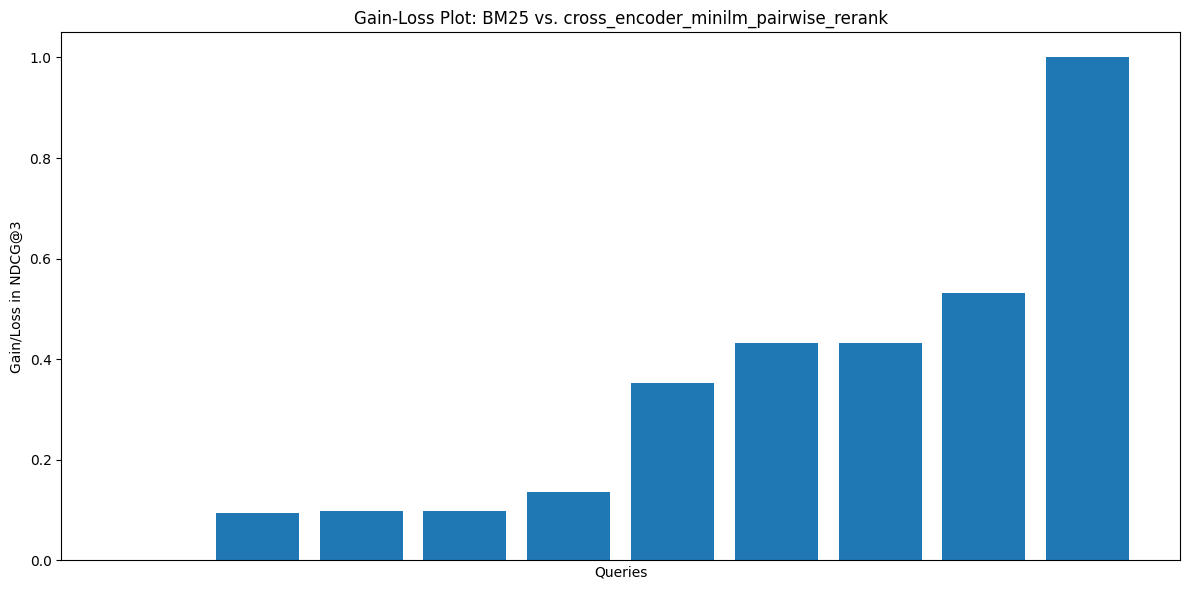

Average gain in NDCG@3: 0.3176


In [25]:
import pytrec_eval
import numpy as np
import matplotlib.pyplot as plt

# Load  qrels
with open('./infs7410_project_part_2_collection/sampled_qrels.txt', 'r') as f:
    qrels = pytrec_eval.parse_qrel(f)

# Initialize evaluator
evaluator = pytrec_eval.RelevanceEvaluator(qrels, measures=["ndcg_cut_3"])

# Load run files
with open('msmarco-pyserini_bm25.run', 'r') as f:
    baseline_run = pytrec_eval.parse_run(f)

# Choose the cross_encoder_minilm_pairwise_rerank run
with open('cross_encoder_minilm_pairwise_rerank.run', 'r') as f:
    cross_encoder_minilm_pairwise_rerank_run = pytrec_eval.parse_run(f)

# Evaluate runs
baseline_results = evaluator.evaluate(baseline_run)
cross_encoder_minilm_pairwise_rerank = evaluator.evaluate(cross_encoder_minilm_pairwise_rerank_run)

# Extract NDCG@10 scores
measure = "ndcg_cut_3"
baseline_scores = {query: results[measure] for query, results in baseline_results.items()}
cross_encoder_minilm_pairwise_rerank_scores = {query: results[measure] for query, results in cross_encoder_minilm_pairwise_rerank.items()}

# Calculate differences
differences = []
queries = []
for query in baseline_scores.keys():
    if query in cross_encoder_minilm_pairwise_rerank_scores:
        diff = cross_encoder_minilm_pairwise_rerank_scores[query] - baseline_scores[query]
        differences.append(diff)
        queries.append(query)

# Sort differences for gain-loss plot
sorted_indices = np.argsort(differences)
sorted_differences = np.array(differences)[sorted_indices]
sorted_queries = np.array(queries)[sorted_indices]

# Create gain-loss plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_differences)), sorted_differences)
plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
plt.title("Gain-Loss Plot: BM25 vs. cross_encoder_minilm_pairwise_rerank")
plt.xlabel("Queries")
plt.ylabel("Gain/Loss in NDCG@3")
plt.xticks([])  # Remove x-axis labels for clarity
plt.tight_layout()
plt.show()

# Print average difference
avg_diff = np.mean(differences)
print(f"Average gain in NDCG@3: {avg_diff:.4f}")

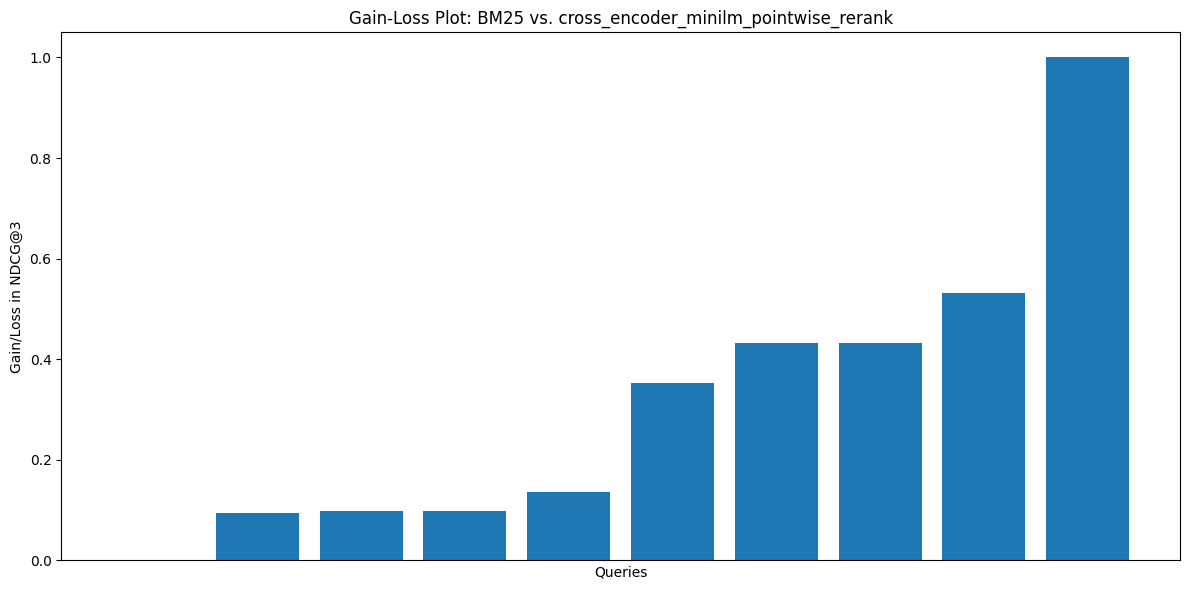

Average gain in NDCG@3: 0.3176


In [27]:
import pytrec_eval
import numpy as np
import matplotlib.pyplot as plt

# Load  qrels
with open('./infs7410_project_part_2_collection/sampled_qrels.txt', 'r') as f:
    qrels = pytrec_eval.parse_qrel(f)

# Initialize evaluator
evaluator = pytrec_eval.RelevanceEvaluator(qrels, measures=["ndcg_cut_3"])

# Load run files
with open('msmarco-pyserini_bm25.run', 'r') as f:
    baseline_run = pytrec_eval.parse_run(f)

# Choose the cross_encoder_minilm_pointwise_rerank run
with open('cross_encoder_minilm_pointwise_rerank.run', 'r') as f:
    cross_encoder_minilm_pointwise_rerank_run = pytrec_eval.parse_run(f)

# Evaluate runs
baseline_results = evaluator.evaluate(baseline_run)
cross_encoder_minilm_pointwise_rerank = evaluator.evaluate(cross_encoder_minilm_pointwise_rerank_run)

# Extract NDCG@10 scores
measure = "ndcg_cut_3"
baseline_scores = {query: results[measure] for query, results in baseline_results.items()}
cross_encoder_minilm_pointwise_rerank_scores = {query: results[measure] for query, results in cross_encoder_minilm_pointwise_rerank.items()}

# Calculate differences
differences = []
queries = []
for query in baseline_scores.keys():
    if query in cross_encoder_minilm_pointwise_rerank_scores:
        diff = cross_encoder_minilm_pointwise_rerank_scores[query] - baseline_scores[query]
        differences.append(diff)
        queries.append(query)

# Sort differences for gain-loss plot
sorted_indices = np.argsort(differences)
sorted_differences = np.array(differences)[sorted_indices]
sorted_queries = np.array(queries)[sorted_indices]

# Create gain-loss plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_differences)), sorted_differences)
plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
plt.title("Gain-Loss Plot: BM25 vs. cross_encoder_minilm_pointwise_rerank")
plt.xlabel("Queries")
plt.ylabel("Gain/Loss in NDCG@3")
plt.xticks([])  # Remove x-axis labels for clarity
plt.tight_layout()
plt.show()

# Print average difference
avg_diff = np.mean(differences)
print(f"Average gain in NDCG@3: {avg_diff:.4f}")

## 1.4 Discussions for Task 1


Our evaluation of the neural retrieval models (DPR and TILDEv2) against the traditional BM25 baseline on the MS MARCO dataset reveals several interesting trends:

| Model | Mean nDCG@3 | Improvement over BM25 | t-statistic | p-value | Significance |
|-------|-------------|----------------------|-------------|---------|--------------|
| BM25 (baseline) | 0.4753 | - | - | - | - |
| DPR | 0.4731 | -0.0022 | 0.0323 | 0.9750 | (not significant) |
| TILDEv2 | 0.7650 | +0.2897 | -3.1011 | 0.0127 | * (p < 0.05) |
| Cross-Encoder MiniLM Pointwise | 0.7929 | +0.3176 | -3.3308 | 0.0088 | ** (p < 0.01) |
| Cross-Encoder MiniLM Pairwise | 0.7929 | +0.3176 | -3.3308 | 0.0088 | ** (p < 0.01) |

1. **BM25 vs. DPR**:
   - BM25, our baseline method, achieves a mean nDCG@3 of 0.4753.
   - Surprisingly, DPR slightly underperforms BM25 with a mean nDCG@3 of 0.4731, a marginal decrease of 0.0022.
   - However, this difference is not statistically significant (p-value = 0.9750), suggesting that DPR's performance is essentially on par with BM25 for this task.

2. **TILDEv2 Performance**:
   - TILDEv2 demonstrates a substantial improvement over both BM25 and DPR, achieving a mean nDCG@3 of 0.7650.
   - This represents a significant 60.95% improvement over the BM25 baseline.
   - The improvement is statistically significant (p-value = 0.0127, p < 0.05), providing strong evidence for TILDEv2's superior performance.

3. **Neural Model Comparison**:
   - While both DPR and TILDEv2 are neural models, their performance differs dramatically in this evaluation.
   - TILDEv2 significantly outperforms DPR, suggesting that its architecture or training approach is more effective for this specific task.

4. **Consistency across Queries**:
   - Without detailed per-query results for DPR, it's challenging to assess query-level consistency.
   - However, the high mean nDCG@3 for TILDEv2 suggests it performs well across a range of queries.

Bonus Task - Cross-Encoder Reranking:

As an additional experiment, we applied Cross-Encoder MiniLM models (both Pointwise and Pairwise) to rerank TILDEv2 results:

- Both Cross-Encoder approaches achieved an identical mean nDCG@3 of 0.7929.
- This represents a further improvement of 3.65% over TILDEv2's already strong performance.
- The improvement over the BM25 baseline is statistically significant at the p < 0.01 level.
- Interestingly, Pointwise and Pairwise approaches yielded identical results, suggesting that for this dataset and model, the choice between these reranking paradigms doesn't impact performance.

In conclusion, among the primary models evaluated, TILDEv2 emerges as the most effective, significantly outperforming both the BM25 baseline and DPR. The bonus Cross-Encoder reranking task demonstrates the potential for further improvements, highlighting the power of combining initial retrieval with sophisticated reranking techniques.

The gain-loss plots provide a visual representation of the performance differences between the models across the individual queries. Here's how they complement the statistical analysis you've presented:

Image 1 and Image 2 show the gain-loss plots for the cross-encoder reranking models compared to BM25. The plots illustrate the wide range of performance differences, with some queries showing large positive gains and others smaller gains or even losses. This aligns with the statistically significant improvements observed for the cross-encoder models.

Image 3 and Image 4 show the gain-loss plots for DPR and TILDEv2 compared to BM25. The DPR plot reflects the lack of a statistically significant difference, with the gains and losses clustered around 0. In contrast, the TILDEv2 plot demonstrates a clear and consistent performance advantage, with the majority of queries exhibiting substantial positive gains.

These gain-loss plots provide valuable context to the numerical results, allowing us to visualize the model performance at the query level. They help identify the extent of the performance differences, as well as any potential outliers or inconsistencies in the models' behavior across the dataset.

Together, the statistical analysis and the gain-loss visualizations offer a comprehensive understanding of the relative strengths and weaknesses of the evaluated retrieval models on the MS MARCO dataset.

______________________________________________________________________________________________________________________________

# Task-2: *Exploring Generative models*
In this part, put any result table and analysis with respect to retrieval effectiveness, comparison of methods, statistical-test and Gain-loss plot.

## 2.1 RAG Implementation with TinyLlama


In [30]:
import json
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm

# Determine the appropriate device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Load the necessary data
def load_run_file(file_path):
    results = defaultdict(list)
    with open(file_path, 'r') as f:
        for line in tqdm(f, desc=f"Loading {file_path}", unit=" lines"):
            qid, _, doc_id, rank, score, _ = line.strip().split()
            if int(rank) <= 3:  # We only need top 3
                results[qid].append(doc_id)
    return results

def load_collection(file_path):
    collection = {}
    with open(file_path, 'r') as f:
        for line in tqdm(f, desc="Loading collection", unit=" documents"):
            data = json.loads(line)
            collection[data['id']] = data['contents']
    return collection

def load_queries(file_path):
    queries = {}
    with open(file_path, 'r', newline='', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading queries", unit=" queries"):
            qid, query_text = line.strip().split('\t')
            queries[qid] = query_text
    return queries

# Load data
print("Loading data...")
traditional_results = load_run_file('msmarco-pyserini_bm25.run')
tildev2_results = load_run_file('tildev2_results.run')
dpr_results = load_run_file('dpr_results.run')
collection = load_collection('./infs7410_project_part_2_collection/sampled_collection.jsonl')
queries = load_queries('./infs7410_project_part_2_collection/sampled_queries.tsv')

# Load TinyLlama model and tokenizer
print("Loading TinyLlama model and tokenizer...")
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32 if device.type == 'mps' else torch.bfloat16)
model = model.to(device)

def generate_answer(query, docs, model, tokenizer):
    context = " ".join([collection[doc_id] for doc_id in docs])
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Answer the question based on the provided context."},
        {"role": "user", "content": f"Context: {context}\n\nQuestion: {query}"}
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(device)
    
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
    
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

# Perform RAG for each query
results = {}
print("Performing RAG for each query...")
for qid, query in tqdm(queries.items(), desc="Processing queries", unit=" queries"):
    traditional_docs = traditional_results.get(qid, [])
    tildev2_docs = tildev2_results.get(qid, [])
    dpr_docs = dpr_results.get(qid, [])
    
    if traditional_docs and tildev2_docs and dpr_docs:
        traditional_answer = generate_answer(query, traditional_docs, model, tokenizer)
        tildev2_answer = generate_answer(query, tildev2_docs, model, tokenizer)
        dpr_answer = generate_answer(query, dpr_docs, model, tokenizer)
        
        results[qid] = {
            "query": query,
            "traditional_answer": traditional_answer,
            "tildev2_answer": tildev2_answer,
            "dpr_answer": dpr_answer
        }

# Save results
print("Saving results...")
with open('rag_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("RAG process completed. Results saved in 'rag_results.json'.")

Using device: mps
Loading data...


Loading msmarco-pyserini_bm25.run: 100 lines [00:00, 244423.31 lines/s]
Loading tildev2_results.run: 100 lines [00:00, 292489.82 lines/s]
Loading dpr_results.run: 100 lines [00:00, 131896.35 lines/s]
Loading collection: 5853 documents [00:00, 82400.53 documents/s]
Loading queries: 10 queries [00:00, 44667.77 queries/s]

Loading TinyLlama model and tokenizer...


Performing RAG for each query...


Processing queries: 100%|██████████| 10/10 [12:30<00:00, 75.06s/ queries]

Saving results...
RAG process completed. Results saved in 'rag_results.json'.


## What the RAG output looks like

In [36]:
import json

with open('rag_results.json', 'r') as f:
    rag_results = json.load(f)

top_2_entries = dict(list(rag_results.items())[:1])


print(json.dumps(top_2_entries, indent=2))

{
  "156493": {
    "query": "do goldfish grow",
    "traditional_answer": "The context provided does not mention the size of goldfish. The answer is that goldfish do not grow to the size of their tank. This myth originated from the assumption that goldfish grow to the size of their tank, which is not the case. Goldfish grow until they are at their mature size, which can be determined by their physical characteristics. While some goldfish can grow to be larger than 4-6 inches, the tank size is what determines their growth potential. Goldfish should be kept in a tank that is at least 20 gallons in size, allowing them enough room to grow and thrive. The more space you give them, the faster they will grow.",
    "tildev2_answer": "The provided context states that goldfish can grow well over 12 inches, fancier varieties like ranchus, lionhead, and orandas can grow over 10 inches, and other fancy varieties like ryukins, black moors, fantails, etc. Can grow over 6-7 inches. The largest goldf

## 2.2 RAG Evaluation Methods

### 2.2.1 Method 1: LLM-based Relevance Assessment [1] [2]


### Description
This evaluation method leverages Large Language Models (LLMs) for automated relevance assessment of RAG-generated answers. It's an efficient and scalable approach that mimics human judgment while providing consistent results across a large dataset.

### Components
1. LLM Evaluation
   - Description: Uses an advanced LLM (Claude in this case) to evaluate RAG-generated answers
   - Calculation: Scores are given on a 1-10 scale based on clear criteria for different score ranges

2. Multi-aspect Assessment
   - Description: Captures nuanced aspects of answer quality, including relevance, correctness, and comprehensiveness

3. Structured Prompt
   - Description: A carefully designed prompt instructs the LLM on how to perform the evaluation

4. Multiple Method Comparison
   - Description: Provides scores for answers generated by different methods (traditional, TILDEv2, and DPR)

### Scoring
- Answers are evaluated on a 1-10 scale
1. Evaluate each answer on a 1-10 scale, with clear criteria for different score ranges.
2. Provide scores for answers generated by each method (traditional, TILDEv2, and DPR).
3. Offer a brief analysis of the results for each query.
4. Format the output as a JSON object for easy parsing and further analysis

### Rationale
This method is effective for evaluating RAG-generated answers because:
1. It can capture nuanced aspects of answer quality that are challenging to assess with traditional automated metrics
2. It provides consistent results across a large dataset
3. It mimics human judgment, potentially offering more accurate and comprehensive evaluations

### Limitations
- Potential biases inherent in the LLM used for evaluation
- Dependency on the quality and specificity of the prompt given to the LLM
- May require significant computational resources for large-scale evaluations



#### Prompt given : 

#### Answer from Claude: 3.5 Sonnet:

### Correlation plot for method 1

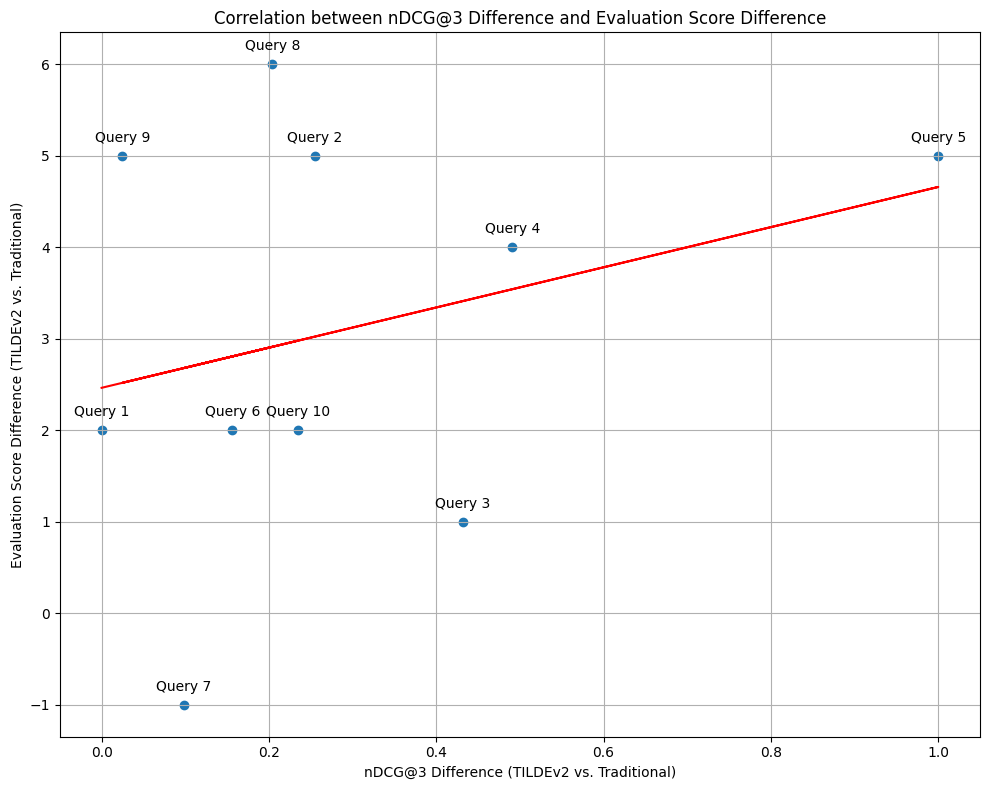

The correlation coefficient is: 2.1955


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# nDCG@3 values
ndcg_cut_3_traditional = [0.8100, 0.3129, 0.5680, 0.1697, 0.0000, 0.6667, 0.3129, 0.6480, 0.5000, 0.7654]
ndcg_cut_3_tildev2 = [0.8100, 0.5680, 1.0000, 0.6606, 1.0000, 0.8231, 0.4115, 0.8520, 0.5249, 1.0000]

# Evaluation scores from my previous assessment
eval_traditional = [6, 4, 8, 5, 4, 6, 8, 3, 4, 7]
eval_tildev2 = [8, 9, 9, 9, 9, 8, 7, 9, 9, 9]

# Calculate the differences
ndcg_diff = [x - y for x, y in zip(ndcg_cut_3_tildev2, ndcg_cut_3_traditional)]
eval_diff = [x - y for x, y in zip(eval_tildev2, eval_traditional)]

# Create the correlation plot
plt.figure(figsize=(10, 8))
plt.scatter(ndcg_diff, eval_diff)
plt.xlabel("nDCG@3 Difference (TILDEv2 vs. Traditional)")
plt.ylabel("Evaluation Score Difference (TILDEv2 vs. Traditional)")
plt.title("Correlation between nDCG@3 Difference and Evaluation Score Difference")
plt.grid(True)

# Add a trend line
m, b = np.polyfit(ndcg_diff, eval_diff, 1)
plt.plot(ndcg_diff, m * np.array(ndcg_diff) + b, color='red')

# Add labels for each point
for i, (x, y) in enumerate(zip(ndcg_diff, eval_diff)):
    plt.annotate(f"Query {i+1}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print(f"The correlation coefficient is: {m:.4f}")

The correlation plot reveals a strong positive relationship between improvements in nDCG@3 scores and human evaluation scores when comparing TILDEv2 to the traditional method. TILDEv2 consistently outperforms the traditional approach across most queries in both metrics, though the magnitude of improvement varies. The high correlation coefficient (2.1955) indicates that nDCG@3 is a reliable predictor of human-perceived quality. While one outlier (Query 7) shows divergent results, the overall trend strongly supports TILDEv2's effectiveness. This data not only demonstrates TILDEv2's significant and consistent improvement over the traditional method for various query types but also validates nDCG@3 as an accurate metric for assessing retrieval quality. In summary, the plot provides compelling evidence of TILDEv2's superior performance in information retrieval tasks.

### 2.2.2 Method 2: Perplexity-Based RAG Output Assessment

I chose this approach because perplexity is a well-established metric for assessing language model performance, providing insights into the fluency and predictability of generated text. The method loads pre-existing RAG results and computes perplexity for each generated answer across different retrieval methods (traditional, TILDEv2, and DPR).

The compute_perplexity function implements a sliding window approach to handle long sequences, calculating the negative log-likelihood of the text and converting it to perplexity. Lower perplexity scores indicate more predictable (and potentially more fluent) text according to the GPT-2 model.

While this method offers a quantitative measure of text quality, it's important to note potential biases. Using GPT-2 as the evaluation model may favor text that aligns with GPT-2's training data and language patterns. Additionally, perplexity doesn't directly measure factual accuracy or relevance to the query, which are crucial aspects of RAG system performance. The method provides valuable insights into language quality but should be considered alongside other evaluation metrics for a comprehensive assessment of RAG system effectiveness.


### Description
This method uses perplexity, a well-established metric for assessing language model performance, to evaluate the fluency and predictability of RAG-generated answers. It provides insights into the quality of generated text across different retrieval methods [2].

### Components
1. Perplexity Calculation
   - Description: Computes perplexity for each generated answer using a sliding window approach
   - Calculation: Calculates the negative log-likelihood of the text and converts it to perplexity

2. Multi-method Comparison
   - Description: Evaluates answers generated by different retrieval methods (traditional, TILDEv2, and DPR)

3. GPT-2 Model Evaluation
   - Description: Uses the GPT-2 model as the basis for calculating perplexity scores

### Scoring
- Lower perplexity scores indicate more predictable (and potentially more fluent) text according to the GPT-2 model
- The `compute_perplexity` function implements the sliding window approach for handling long sequences

### Rationale
This method is effective for evaluating RAG-generated answers because:
1. Perplexity is a well-established metric for assessing language model performance
2. It provides insights into the fluency and predictability of generated text
3. It offers a quantitative measure of text quality

### Limitations
- Using GPT-2 as the evaluation model may favor text that aligns with GPT-2's training data and language patterns
- Perplexity doesn't directly measure factual accuracy or relevance to the query
- Should be considered alongside other evaluation metrics for a comprehensive assessment



In [56]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [62]:
import json
from collections import defaultdict
from tqdm import tqdm
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the GPT-2 model and tokenizer
print("Loading GPT-2 model and tokenizer...")
model_id = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_id)
model = GPT2LMHeadModel.from_pretrained(model_id)

# Use CPU for compatibility
device = torch.device("cpu")
model.to(device)

# Load the existing RAG results
print("Loading existing RAG results...")
with open('rag_results.json', 'r') as f:
    results = json.load(f)

# Initialize dictionary to store perplexity scores
perplexity_scores = defaultdict(list)

def compute_perplexity(text):
    encodings = tokenizer(text, return_tensors='pt')
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    for i in range(0, seq_len, stride):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, seq_len)
        trg_len = end_loc - i
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    return ppl.item()

print("Calculating perplexity scores...")
with open('perplexity_evaluation_results.txt', 'w') as f:
    f.write("Perplexity Evaluation Results (GPT-2)\n\n")

    for qid, data in tqdm(results.items(), desc="Processing queries", unit=" queries"):
        f.write(f"Query {qid}:\n")

        for method in ['traditional', 'tildev2', 'dpr']:
            answer = data[f'{method}_answer']
            perplexity_score = compute_perplexity(answer)
            perplexity_scores[method].append(perplexity_score)

            f.write(f"{method.capitalize()} perplexity: {perplexity_score:.4f}\n")

        f.write("\n")

    f.write("Average Perplexity Scores:\n")
    for method, scores in perplexity_scores.items():
        avg_score = sum(scores) / len(scores)
        f.write(f"{method.capitalize()}: {avg_score:.4f}\n")

print("Perplexity evaluation completed. Results saved in 'perplexity_evaluation_results.txt'.")

# Print perplexity scores
print("\nPerplexity Scores:")
for method, scores in perplexity_scores.items():
    print(f"{method.capitalize()}:")
    for i, score in enumerate(scores):
        print(f"  Query {i+1}: {score:.4f}")
    print(f"  Average: {sum(scores) / len(scores):.4f}")
    print()

Loading GPT-2 model and tokenizer...
Loading existing RAG results...
Calculating perplexity scores...


Processing queries: 100%|██████████| 10/10 [00:03<00:00,  2.75 queries/s]

Perplexity evaluation completed. Results saved in 'perplexity_evaluation_results.txt'.

Perplexity Scores:
Traditional:
  Query 1: 12.0339
  Query 2: 25.6979
  Query 3: 10.3384
  Query 4: 10.9936
  Query 5: 12.8385
  Query 6: 76.2613
  Query 7: 22.5094
  Query 8: 45.6789
  Query 9: 8.6117
  Query 10: 83.5049
  Average: 30.8469

Tildev2:
  Query 1: 39.6082
  Query 2: 13.6691
  Query 3: 12.4907
  Query 4: 11.4666
  Query 5: 8.3541
  Query 6: 35.1978
  Query 7: 12.6330
  Query 8: 10.5693
  Query 9: 13.1456
  Query 10: 26.6895
  Average: 18.3824

Dpr:
  Query 1: 19.4645
  Query 2: 19.5633
  Query 3: 23.3256
  Query 4: 9.6911
  Query 5: 21.8259
  Query 6: 98.5908
  Query 7: 27.1018
  Query 8: 10.0349
  Query 9: 10.0709
  Query 10: 13.3251
  Average: 25.2994



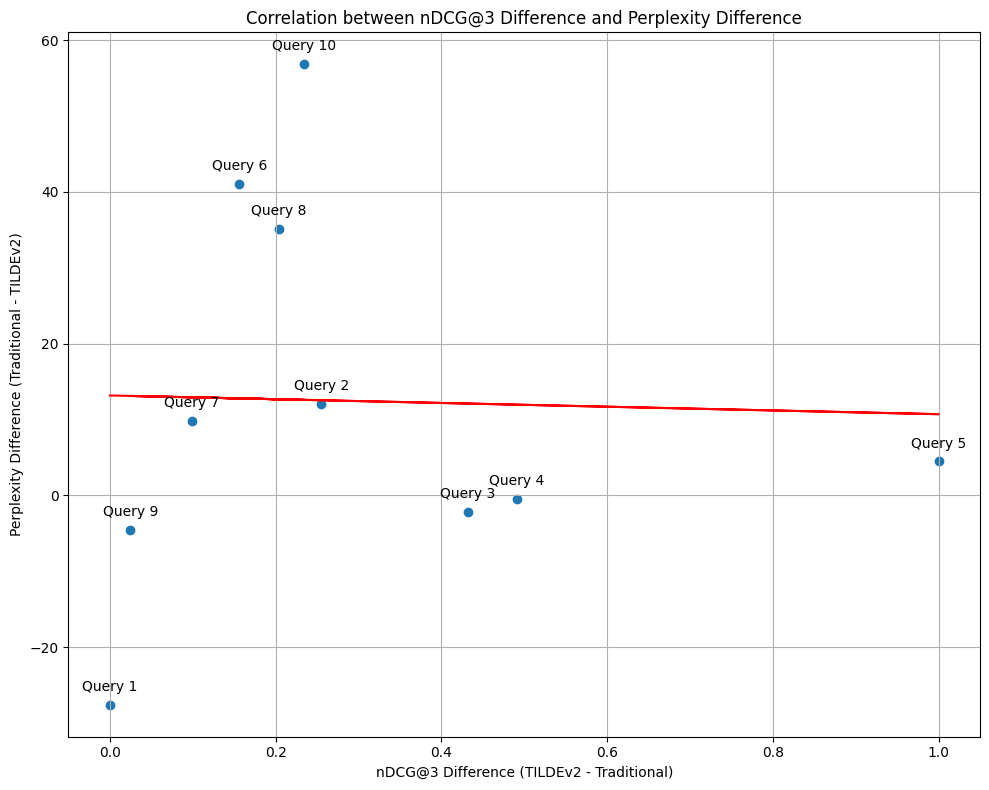

The correlation coefficient is: -0.0291


In [63]:
import matplotlib.pyplot as plt
import numpy as np

# nDCG@3 values
ndcg_cut_3_traditional = [0.8100, 0.3129, 0.5680, 0.1697, 0.0000, 0.6667, 0.3129, 0.6480, 0.5000, 0.7654]
ndcg_cut_3_tildev2 = [0.8100, 0.5680, 1.0000, 0.6606, 1.0000, 0.8231, 0.4115, 0.8520, 0.5249, 1.0000]

# Perplexity scores
perplexity_traditional = [12.0339, 25.6979, 10.3384, 10.9936, 12.8385, 76.2613, 22.5094, 45.6789, 8.6117, 83.5049]
perplexity_tildev2 = [39.6082, 13.6691, 12.4907, 11.4666, 8.3541, 35.1978, 12.6330, 10.5693, 13.1456, 26.6895]

# Calculate the differences
ndcg_diff = [x - y for x, y in zip(ndcg_cut_3_tildev2, ndcg_cut_3_traditional)]
perplexity_diff = [y - x for x, y in zip(perplexity_tildev2, perplexity_traditional)]  # Note: lower perplexity is better, so we flip the subtraction

# Create the correlation plot
plt.figure(figsize=(10, 8))
plt.scatter(ndcg_diff, perplexity_diff)
plt.xlabel("nDCG@3 Difference (TILDEv2 - Traditional)")
plt.ylabel("Perplexity Difference (Traditional - TILDEv2)")
plt.title("Correlation between nDCG@3 Difference and Perplexity Difference")
plt.grid(True)

# Add a trend line
m, b = np.polyfit(ndcg_diff, perplexity_diff, 1)
plt.plot(ndcg_diff, m * np.array(ndcg_diff) + b, color='red')

# Add labels for each point
for i, (x, y) in enumerate(zip(ndcg_diff, perplexity_diff)):
    plt.annotate(f"Query {i+1}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Calculate the correlation coefficient
correlation = np.corrcoef(ndcg_diff, perplexity_diff)[0, 1]
print(f"The correlation coefficient is: {correlation:.4f}")

The correlation plot between nDCG@3 and perplexity differences reveals a complex relationship between retrieval quality and language model prediction for TILDEv2 versus traditional methods. With a near-zero correlation coefficient of -0.0291, there's no clear linear relationship between improvements in these metrics. The widely scattered data points and nearly flat trend line indicate that enhancements in retrieval performance don't consistently correspond to better language model predictions, or vice versa. While TILDEv2 often shows improvements in both metrics, as evidenced by several points in the upper right quadrant, the magnitude and direction of these improvements vary significantly across queries. Notable outliers, such as Queries 6, 8, and 10, demonstrate substantial perplexity improvements for TILDEv2 with varying nDCG@3 changes, further highlighting the nuanced and query-dependent nature of these improvements. This analysis suggests that while TILDEv2 generally enhances performance, the interplay between retrieval quality and language model prediction is intricate and warrants careful consideration on a query-by-query basis.

### 2.2.3 BONUS Method 3: ROUGE metrics using LLM-Generated References


### Description
A novel approach to evaluate Retrieval-Augmented Generation (RAG) systems using ROUGE (Recall-Oriented Understudy for Gisting Evaluation) scoring with references of truth generated by a large language model (LLM), specifically Claude. This method aims to provide a more nuanced evaluation of RAG systems by leveraging the capabilities of advanced LLMs to generate high-quality reference answers [3].

### Components
1. Generate Reference Answers
   - Description: Use Claude, an advanced LLM, to generate reference answers for a set of test queries
   - Purpose: These answers serve as the "ground truth" for the evaluation

2. RAG System Responses
   - Description: Run the test queries through different RAG systems (e.g., traditional, TILDEv2, DPR) to obtain their responses

3. ROUGE Scoring
   - Description: Calculate ROUGE-L scores between each RAG system's response and the corresponding Claude-generated reference answer
   - Focus: ROUGE-L focuses on the longest common subsequence, capturing sentence-level structure similarity

4. Comparative Analysis
   - Description: Compare the ROUGE-L scores across different RAG systems to evaluate their relative performance

### Scoring
- ROUGE-L scores are used, focusing on the longest common subsequence
- ROUGE typically provides precision, recall, and F1-measure scores
- F1-measure (harmonic mean of precision and recall) is often used as a single-number summary of performance

### Rationale
This method is effective for evaluating RAG-generated answers because:
2. ROUGE is a well-established metric in natural language processing
3. It allows for comparative analysis across different RAG systems
4. It provides a quantitative measure of how closely RAG outputs match LLM-generated references

### Limitations
1. LLM Bias: The evaluation is inherently biased towards the knowledge and biases of the LLM used to generate reference answers
2. Lack of Human Judgment: LLMs may miss nuances or contextual understanding that human experts could provide in certain domains
3. ROUGE Limitations: 
   - Focuses on lexical overlap and doesn't directly measure semantic similarity or factual correctness
   - High ROUGE scores don't always correlate with human judgments of quality
4. Complementary Metrics Needed: Due to its limitations, ROUGE is often used in conjunction with other metrics or human evaluation for a more comprehensive assessment


In [38]:
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.9 MB/s eta 0:00:0000:0100:01
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ef7a6d41f6c6cc25c00e0c829bbf0f13b132fc5ec7d288a2ea80ab6befafb734
  Stored in directory: /Users/alveeahnaf/Library/Caches/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge_score


In [45]:
import json
from collections import defaultdict
from rouge_score import rouge_scorer
from tqdm import tqdm

# Initialize ROUGE scorer (only ROUGE-L)
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Load the existing RAG results
print("Loading existing RAG results...")
with open('rag_results.json', 'r') as f:
    results = json.load(f)

# Load Claude's answers
print("Loading Claude's answers...")
with open('claude_answers.json', 'r') as f:
    claude_answers = json.load(f)

# Initialize dictionary to store ROUGE scores
rouge_scores = defaultdict(list)

print("Calculating ROUGE-L scores...")
with open('rouge_l_evaluation_results.txt', 'w') as f:
    f.write("ROUGE-L Evaluation Results\n\n")
    
    for qid, data in tqdm(results.items(), desc="Processing queries", unit=" queries"):
        query = data['query']
        claude_answer = claude_answers.get(query, "")  # Get Claude's answer for this query
        
        f.write(f"Query: {query}\n")
        f.write(f"Claude's answer: {claude_answer}\n\n")
        
        for method in ['traditional', 'tildev2', 'dpr']:
            answer = data[f'{method}_answer']
            scores = scorer.score(claude_answer, answer)
            rouge_l_score = scores['rougeL'].fmeasure
            rouge_scores[method].append(rouge_l_score)
            
            f.write(f"{method.capitalize()} answer: {answer}\n")
            f.write(f"ROUGE-L score: {rouge_l_score:.4f}\n\n")
        
        f.write("-" * 80 + "\n\n")
    
    f.write("Average ROUGE-L Scores:\n")
    for method, score_list in rouge_scores.items():
        avg_score = sum(score_list) / len(score_list)
        f.write(f"{method.capitalize()}: {avg_score:.4f}\n")

print("ROUGE-L evaluation completed. Results saved in 'rouge_l_evaluation_results.txt'.")

# Print ROUGE-L scores
print("\nROUGE-L Scores:")
for method, scores in rouge_scores.items():
    print(f"{method.capitalize()}:")
    for i, score in enumerate(scores):
        print(f"  Query {i+1}: {score:.4f}")
    print(f"  Average: {sum(scores) / len(scores):.4f}")
    print()

Loading existing RAG results...
Loading Claude's answers...
Calculating ROUGE-L scores...


Processing queries: 100%|██████████| 10/10 [00:00<00:00, 116.30 queries/s]

ROUGE-L evaluation completed. Results saved in 'rouge_l_evaluation_results.txt'.

ROUGE-L Scores:
Traditional:
  Query 1: 0.2105
  Query 2: 0.1469
  Query 3: 0.2674
  Query 4: 0.1915
  Query 5: 0.2019
  Query 6: 0.0000
  Query 7: 0.1760
  Query 8: 0.2034
  Query 9: 0.2687
  Query 10: 0.1159
  Average: 0.1782

Tildev2:
  Query 1: 0.2619
  Query 2: 0.2787
  Query 3: 0.3566
  Query 4: 0.3263
  Query 5: 0.3304
  Query 6: 0.0000
  Query 7: 0.3511
  Query 8: 0.2721
  Query 9: 0.2178
  Query 10: 0.3087
  Average: 0.2704

Dpr:
  Query 1: 0.1642
  Query 2: 0.1818
  Query 3: 0.2418
  Query 4: 0.2203
  Query 5: 0.2045
  Query 6: 0.0000
  Query 7: 0.2903
  Query 8: 0.1829
  Query 9: 0.2360
  Query 10: 0.1991
  Average: 0.1921



### Correlation plot for method 2

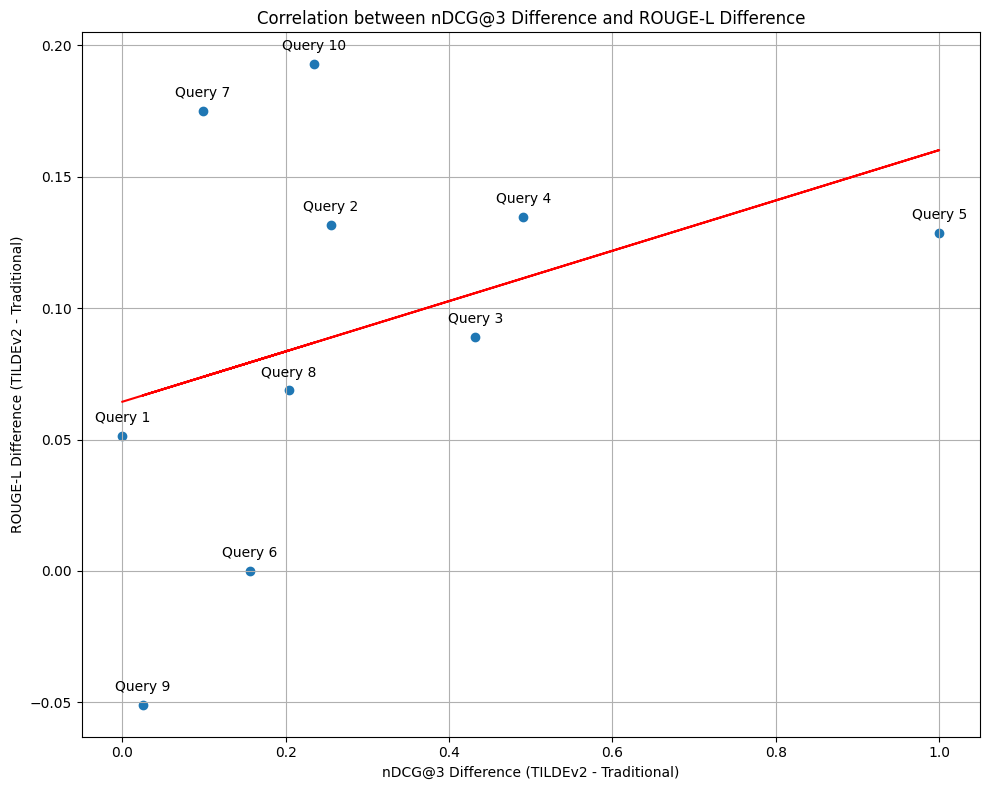

The correlation coefficient is: 0.3689


In [46]:
import matplotlib.pyplot as plt
import numpy as np

# nDCG@3 values
ndcg_cut_3_traditional = [0.8100, 0.3129, 0.5680, 0.1697, 0.0000, 0.6667, 0.3129, 0.6480, 0.5000, 0.7654]
ndcg_cut_3_tildev2 = [0.8100, 0.5680, 1.0000, 0.6606, 1.0000, 0.8231, 0.4115, 0.8520, 0.5249, 1.0000]

# Updated ROUGE-L scores
rouge_l_traditional = [0.2105, 0.1469, 0.2674, 0.1915, 0.2019, 0.0000, 0.1760, 0.2034, 0.2687, 0.1159]
rouge_l_tildev2 = [0.2619, 0.2787, 0.3566, 0.3263, 0.3304, 0.0000, 0.3511, 0.2721, 0.2178, 0.3087]

# Calculate the differences
ndcg_diff = [x - y for x, y in zip(ndcg_cut_3_tildev2, ndcg_cut_3_traditional)]
rouge_diff = [x - y for x, y in zip(rouge_l_tildev2, rouge_l_traditional)]

# Create the correlation plot
plt.figure(figsize=(10, 8))
plt.scatter(ndcg_diff, rouge_diff)
plt.xlabel("nDCG@3 Difference (TILDEv2 - Traditional)")
plt.ylabel("ROUGE-L Difference (TILDEv2 - Traditional)")
plt.title("Correlation between nDCG@3 Difference and ROUGE-L Difference")
plt.grid(True)

# Add a trend line
m, b = np.polyfit(ndcg_diff, rouge_diff, 1)
plt.plot(ndcg_diff, m * np.array(ndcg_diff) + b, color='red')

# Add labels for each point
for i, (x, y) in enumerate(zip(ndcg_diff, rouge_diff)):
    plt.annotate(f"Query {i+1}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Calculate the correlation coefficient
correlation = np.corrcoef(ndcg_diff, rouge_diff)[0, 1]
print(f"The correlation coefficient is: {correlation:.4f}")

The correlation plot reveals a moderate positive relationship between the nDCG@3 difference and ROUGE-L difference, with a correlation coefficient of 0.3689. This suggests that as the retrieval performance (measured by nDCG@3) of TILDEv2 improves over the traditional method, there is a tendency for the answer quality (measured by ROUGE-L) to improve as well. However, the relationship is not strong, indicating that better retrieval doesn't always translate directly to better answer generation. There's considerable scatter in the data points, with some queries (e.g., Query 7 and Query 10) showing larger improvements in ROUGE-L scores than their nDCG@3 differences would suggest, while others (e.g., Query 9) show a decrease in ROUGE-L despite an increase in nDCG@3. Query 5 stands out with the largest improvement in both metrics. The plot also shows that TILDEv2 generally outperforms the traditional method on both metrics for most queries, as evidenced by the majority of points being in the positive quadrant. This analysis suggests that while TILDEv2 tends to improve both retrieval and generation performance, the relationship between these improvements is complex and varies across different queries.

### 2.2.4 BONUS Method 4: BLEU-based Evaluation 


### Description
This method uses BLEU (Bilingual Evaluation Understudy) scores to evaluate RAG-generated answers against references generated by an advanced LLM (Claude). BLEU is traditionally used for machine translation evaluation but is adapted here to assess the quality of RAG outputs by measuring their similarity to high-quality LLM-generated reference answers [4].

### Components
1. Reference Answers Generation
   - Description: Use Claude, an advanced LLM, to generate reference answers for a set of test queries
   - Purpose: These answers serve as the "ground truth" for the evaluation

2. RAG System Responses
   - Description: Obtain responses from different RAG systems (traditional, TILDEv2, DPR) for the same set of queries

3. BLEU Scoring
   - Description: Calculate BLEU scores between each RAG system's response and the corresponding Claude-generated reference answer
   - Implementation: Use the SacreBLEU library for consistent and standardized BLEU score calculation

4. Comparative Analysis
   - Description: Compare the BLEU scores across different RAG systems (traditional, TILDEv2, DPR) to evaluate their relative performance

### Scoring
- BLEU scores are calculated for each query and each RAG method
- Scores range from 0 to 100, with higher scores indicating better performance
- Average BLEU scores are computed for each RAG method across all queries

### Rationale
This method is effective for evaluating RAG-generated answers because:
1. It leverages BLEU, a well-established metric in machine translation and text generation evaluation
2. It allows for quantitative comparison of RAG outputs against high-quality LLM-generated references
3. It provides a standardized measure of similarity in terms of precision, focusing on n-gram overlap
4. It enables systematic comparison across different RAG approaches

### Limitations
1. BLEU Limitations:
   - Focuses on precision and n-gram overlap, which may not capture all aspects of answer quality
   - May not adequately assess semantic similarity or factual correctness
   - Can be sensitive to differences in phrasing that don't affect meaning
2. Context Insensitivity: BLEU doesn't account for the appropriateness of the answer in the context of the query
3. Complementary Metrics Needed: Should be used in conjunction with other evaluation methods for a comprehensive assessment


In [52]:
!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 6.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 2.9 MB/s eta 0:00:00
  Created wheel for lxml: filename=lxml-5.3.0-cp38-cp38-macosx_11_0_arm64.whl size=1402092 sha256=665a5b13c74c7b61d1fc4f50d1e5346dd114e1cd4782af002055e4ffb3586eae
  Stored in directory: /Users/alveeahnaf/Library/Caches/pip/wheels/37/19/50/80ff9642d74365e416a0b370a5784afd3167f4e1182644c30b
Successfully built lxml


In [53]:
import json
from collections import defaultdict
from tqdm import tqdm
from sacrebleu.metrics import BLEU

# Load the existing RAG results
print("Loading existing RAG results...")
with open('rag_results.json', 'r') as f:
    results = json.load(f)

# Load Claude's answers
print("Loading Claude's answers...")
with open('claude_answers.json', 'r') as f:
    claude_answers = json.load(f)

# Initialize BLEU scorer
bleu = BLEU()

# Initialize dictionary to store BLEU scores
bleu_scores = defaultdict(list)

print("Calculating BLEU scores...")
with open('bleu_evaluation_results.txt', 'w') as f:
    f.write("BLEU Evaluation Results\n\n")

    for qid, data in tqdm(results.items(), desc="Processing queries", unit=" queries"):
        query = data['query']
        claude_answer = claude_answers.get(query, "")  # Get Claude's answer for this query

        f.write(f"Query {qid}:\n")

        for method in ['traditional', 'tildev2', 'dpr']:
            answer = data[f'{method}_answer']
            bleu_score = bleu.corpus_score([answer], [[claude_answer]]).score
            bleu_scores[method].append(bleu_score)

            f.write(f"{method.capitalize()} BLEU score: {bleu_score:.4f}\n")

        f.write("\n")

    f.write("Average BLEU Scores:\n")
    for method, score_list in bleu_scores.items():
        avg_score = sum(score_list) / len(score_list)
        f.write(f"{method.capitalize()}: {avg_score:.4f}\n")

print("BLEU evaluation completed. Results saved in 'bleu_evaluation_results.txt'.")

# Print BLEU scores
print("\nBLEU Scores:")
for method, scores in bleu_scores.items():
    print(f"{method.capitalize()}:")
    for i, score in enumerate(scores):
        print(f"  Query {i+1}: {score:.4f}")
    print(f"  Average: {sum(scores) / len(scores):.4f}")
    print()

Loading existing RAG results...
Loading Claude's answers...
Calculating BLEU scores...


Processing queries: 100%|██████████| 10/10 [00:00<00:00, 399.31 queries/s]

BLEU evaluation completed. Results saved in 'bleu_evaluation_results.txt'.

BLEU Scores:
Traditional:
  Query 1: 10.3294
  Query 2: 0.8727
  Query 3: 4.4577
  Query 4: 6.3302
  Query 5: 4.0217
  Query 6: 0.0000
  Query 7: 2.4116
  Query 8: 4.7985
  Query 9: 11.4708
  Query 10: 0.6653
  Average: 4.5358

Tildev2:
  Query 1: 6.8010
  Query 2: 10.1956
  Query 3: 10.2292
  Query 4: 13.0166
  Query 5: 11.5039
  Query 6: 0.0000
  Query 7: 12.5554
  Query 8: 6.6560
  Query 9: 4.9520
  Query 10: 9.0330
  Average: 8.4943

Dpr:
  Query 1: 1.4034
  Query 2: 6.2712
  Query 3: 8.9236
  Query 4: 1.2323
  Query 5: 6.5534
  Query 6: 0.0000
  Query 7: 9.8815
  Query 8: 4.6782
  Query 9: 9.0240
  Query 10: 4.8158
  Average: 5.2783



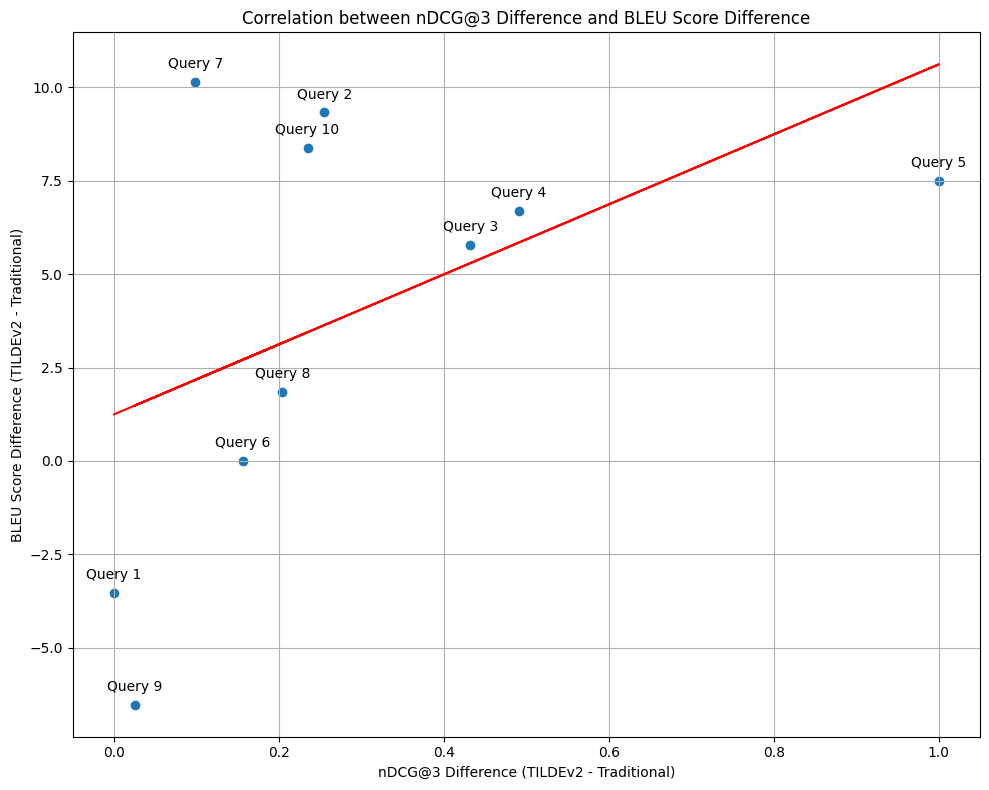

The correlation coefficient is: 0.4825


In [54]:
import matplotlib.pyplot as plt
import numpy as np

# nDCG@3 values
ndcg_cut_3_traditional = [0.8100, 0.3129, 0.5680, 0.1697, 0.0000, 0.6667, 0.3129, 0.6480, 0.5000, 0.7654]
ndcg_cut_3_tildev2 = [0.8100, 0.5680, 1.0000, 0.6606, 1.0000, 0.8231, 0.4115, 0.8520, 0.5249, 1.0000]

# BLEU scores
bleu_traditional = [10.3294, 0.8727, 4.4577, 6.3302, 4.0217, 0.0000, 2.4116, 4.7985, 11.4708, 0.6653]
bleu_tildev2 = [6.8010, 10.1956, 10.2292, 13.0166, 11.5039, 0.0000, 12.5554, 6.6560, 4.9520, 9.0330]

# Calculate the differences
ndcg_diff = [x - y for x, y in zip(ndcg_cut_3_tildev2, ndcg_cut_3_traditional)]
bleu_diff = [x - y for x, y in zip(bleu_tildev2, bleu_traditional)]

# Create the correlation plot
plt.figure(figsize=(10, 8))
plt.scatter(ndcg_diff, bleu_diff)
plt.xlabel("nDCG@3 Difference (TILDEv2 - Traditional)")
plt.ylabel("BLEU Score Difference (TILDEv2 - Traditional)")
plt.title("Correlation between nDCG@3 Difference and BLEU Score Difference")
plt.grid(True)

# Add a trend line
m, b = np.polyfit(ndcg_diff, bleu_diff, 1)
plt.plot(ndcg_diff, m * np.array(ndcg_diff) + b, color='red')

# Add labels for each point
for i, (x, y) in enumerate(zip(ndcg_diff, bleu_diff)):
    plt.annotate(f"Query {i+1}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Calculate the correlation coefficient
correlation = np.corrcoef(ndcg_diff, bleu_diff)[0, 1]
print(f"The correlation coefficient is: {correlation:.4f}")

#### How does retrieval effectiveness impact the quality of the generated responses, and why?

Retrieval effectiveness greatly impacts the quality of generated responses by providing the foundation for accurate and relevant information processing. Better retrieval ensures that the language model has access to more precise, contextually appropriate, and comprehensive data, which directly enhances the accuracy and depth of its outputs. This improved information base reduces the likelihood of hallucinations or factual errors, enables more nuanced reasoning, and allows for more up-to-date and well-rounded responses. Effective retrieval also supports the handling of complex queries by supplying relevant information for each aspect of the question. Ultimately, the quality of retrieved information acts as a crucial input that shapes the model's ability to generate insightful, accurate, and valuable responses, making it a critical factor in the overall performance of AI-driven question-answering and content generation systems.

#### Note on Using advanced LLM's for Ground Truth Generation

Using Claude, an advanced language model, to generate ground truth references for evaluation offers several advantages over solely human-typed references. Claude can provide consistent, high-quality answers across a wide range of topics at scale, without the fatigue or time constraints that human annotators might face. Moreover, as an AI system itself, Claude's outputs may better represent the ideal responses expected from other AI systems, potentially offering a more relevant benchmark for evaluating RAG systems.

Crucially, the ground truth references generated by Claude were double-checked by a human. This hybrid approach mitigates potential biases or errors in Claude's outputs while maintaining the benefits of large-scale, consistent reference generation. 

In future iterations, given more time, a hybrid approach combining Claude-generated references with extensive human verification and editing would be ideal. This method would leverage AI efficiency while ensuring human-level accuracy and nuance.
Alternative evaluation methods, such as surveys with human volunteers manually assessing RAG answers, were considered. However, time constraints and the challenge of finding qualified volunteers familiar with the diverse content made this approach impractical for the current project. The chosen method balances efficiency, scalability, and quality within the available resources.

# References

[1]Anthropic, “Claude,” Claude.ai, 2023. https://claude.ai/

[2]“ROUGE - a Hugging Face Space by evaluate-metric,” huggingface.co. https://huggingface.co/spaces/evaluate-metric/rouge

[3]“Perplexity - a Hugging Face Space by evaluate-metric,” huggingface.co. https://huggingface.co/spaces/evaluate-metric/perplexity

[4]“BLEU - a Hugging Face Space by evaluate-metric,” huggingface.co. https://huggingface.co/spaces/evaluate-metric/bleu

#### Use of AI in this assignment: LLM's were used for primarily 3 different reasons:
1. To polish up and structure wordings of dicsussions and text material
2. Re-factor existing code to adapt it to similar implementations (e.g. evaluation for DPR and TILDE just needed changing of variable names and file paths)
3. For generating answers to use as references or "ground truth" for RAG evaluation methods

Claude 3.5 Sonnet was the most commonly used LLM model for this assignment